# Carrier Tracking

This notebook is a continuation of the Complex_Wave notebook.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode
from GPSData import IQData

# Function to quickly create a wave

In [6]:
def makWav(freqHz, phaseDeg, samples, fs = 4.092*10**6):
    #Initialize terms
    freq = np.exp(1j * 2 * np.pi * (freqHz/fs))
    
    pOffset = np.deg2rad(phaseDeg) 

    phase = np.exp(1j * pOffset)

    #Init samples
    wav = np.zeros(samples, dtype = 'complex')

    
    for n, w in enumerate(wav):
        wav[n] = phase
        phase = phase * freq
    
    return wav

# Signal with two SVs

We will create two signals to practice on. The first will be a signal from satellite 15 that has a doppler shift of 6000 Hz. The other will be satellite 10 with a doppler shift of 1000 Hz.

We are going to assume the Code phase remains locked, and the carrier doppler shift does not change and see if the loop locks on.

In [46]:
carr1 = makWav(6000, 0, 8000)
carr2 = makWav(1000, 0, 8000)

sat = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
           (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
           (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
           (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]

CodeGen1 = GoldCode(sat[14]) #SV 15
CodeGen2 = GoldCode(sat[9]) #SV 10

code1 = CodeGen1.getCode(2000, samplesPerChip = 4)
code2 = CodeGen2.getCode(2000, samplesPerChip = 4)

signal1 = carr1 * code1
signal2 = carr2 * code2

signalboth = signal1 + signal2


/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


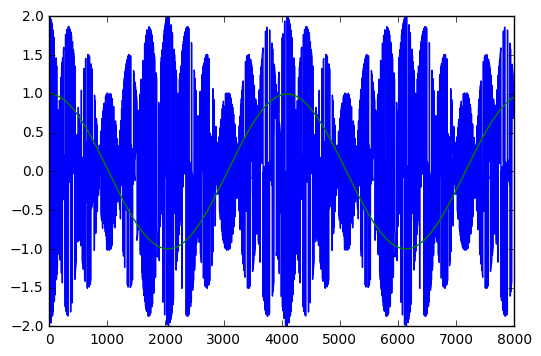

In [47]:
plt.plot(signalboth)
plt.plot(carr2)
plt.show()

# Multiply code 1 to pop out carrier



/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


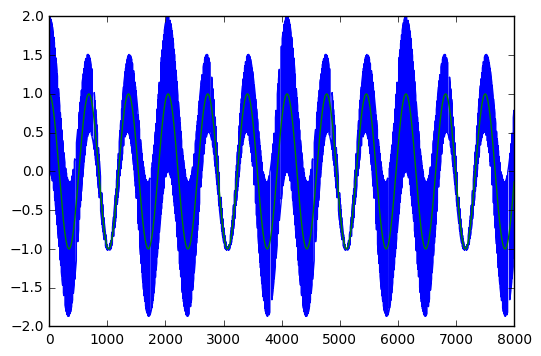

In [54]:
pop1 = signalboth * code1

plt.plot(pop1)
plt.plot(carr1)
plt.show()

In [65]:
zeta = 99
bandwidth = 10
k = 1100

wn = bandwidth * 8 * zeta /\
    (4 * zeta ** 2 + 1)
    
t1 = k / (wn * wn)
t2 = (zeta * 2.0) / wn


print(wn)
print(t1)
print(t2)

0.20201504910088
26954.12501753647
980.125


In [66]:
#Set up the incoming wave

#Pick frequencies
fs = 4.092*10**6 # Sampling Frequency [Hz]
ff = 6000  # Wave Frequency [Hz] 


#Logging Vectors
refWave = np.zeros(len(pop1), dtype='complex')
m = np.zeros(len(pop1))
discriminator = np.zeros(len(pop1))
rf = np.zeros(len(pop1))


#Initialize vars
baseF = ff
refFreq = baseF #Initial frequency

refphase = 1 + 0j #Initial phase

refWave[0] = refphase

adjustment = 0
oldErr = 0
oldRef = 0

#summation interval
interval = 1/fs

#iterate over every sample and adjust
r = [] #ref frequency recording

#iterate over every sample and adjust
for n, samp in enumerate(pop1):
    #Mix
    mixed = pop1[n] / refWave[n]
    #m[n] = mixed
    
    #Check discriminator
    #d = np.angle(mixed) / (2*np.pi)
    d = np.arctan(np.imag(mixed)/np.real(mixed)) / (2*np.pi)
    discriminator[n] = d #Save discriminator
    
    
    #Adjust frequency
    adjustment = oldRef + (d - oldErr) * t1 + d * t2#(7000) + d * 20    
    refFreq = baseF +  adjustment     
    oldRef = adjustment
    
    r.append(refFreq)
    
    oldErr = d
    
    #Calculate next reference frequency sample
    if (n<len(pop1)-1):
        refWave[n + 1] = refWave[n] * np.exp(1j * 2 * np.pi * (refFreq/fs))
    #can[n] = refWave[n] * np.conj(pop1[n])

/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


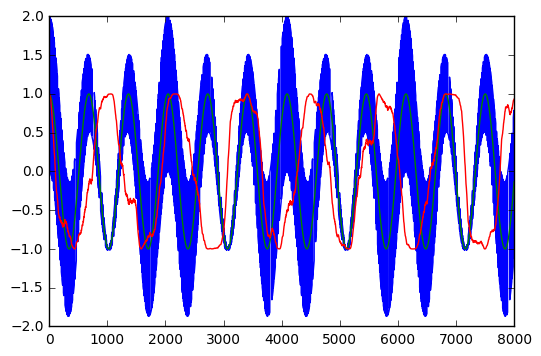

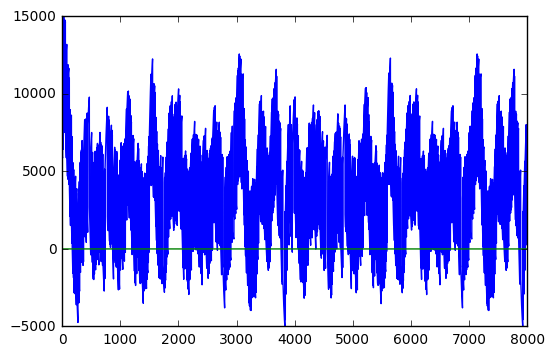

[]

In [73]:
#plt.plot(carr1 * code1)

plt.plot(pop1) 
plt.plot(carr1)
plt.plot(refWave)


plt.show()#plt.plot(carr1 * code1)

plt.plot(r)
plt.show()

plt.plot()

/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


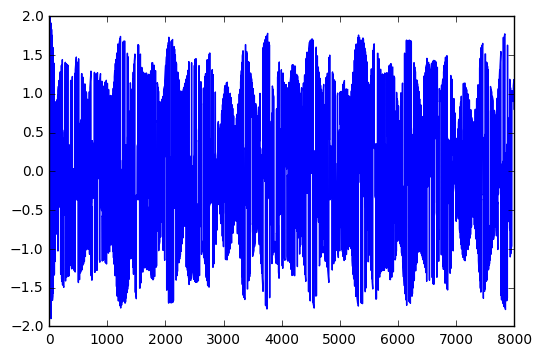

In [53]:
plt.plot(signalboth/refWave)
plt.show()

In [2]:
data = IQData()

# Need these to pass to importFile module
fs = 4.092*10**6 # Sampling Frequency [Hz]
NumberOfMilliseconds = 10
SampleLength = NumberOfMilliseconds*10**(-3)
BytesToSkip = 100000

data.importFile('../resources/test.max', fs, SampleLength, BytesToSkip)
#data.importFile('../resources/JGPS@04.559925043', fs, SampleLength, BytesToSkip)


Opening a file.
File handle is: 52.
Total Samples to read: 40920
Total Bytes read: 20460.
Which equals 40920 IQ pairs.
Sample Length: 0.010000 seconds.
File is now closed.


In [60]:
wav1 = makWav(2000, 0, 4000)
wav2 = makWav(-2000, 0 , 4000)
wavconj = np.conj(wav1)

#Choose which satellite's C/A code is generated
Satellite = 15

# Create list of C/A code Taps, for simpler sat selection",
sat = [(1,5),(2,6),(3,7),(4,8),(0,8),(1,5),(0,7),(1,8),(2,9),(1,2),(2,3),(4,5),(5,6),(6,7),(7,8),(8,9),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(0,2),(3,5),(4,6),(5,7),(6,8),(7,9),(0,5),(1,6),(2,7),(3,8),(4,9),(3,9),(0,6),(1,7),(3,9)]
CodeGen = GoldCode(sat[Satellite - 1]) 
CACode = CodeGen.getCode(1000, samplesPerChip = 4)

wavmod = wav1 * CACode

/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


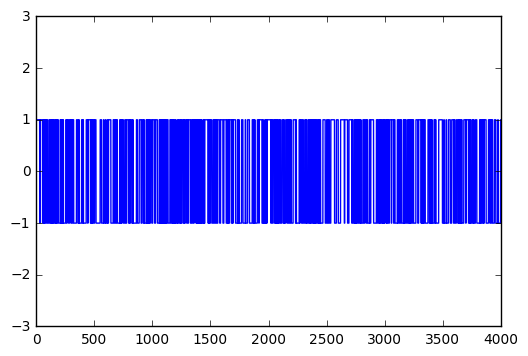

In [127]:
plt.plot(wavmod * np.conj(wav1))
plt.ylim([-3,3])
plt.show()

In [7]:
incWav= data.CData

#Logging Vectors
refWave = np.zeros(len(incWav), dtype='complex')
m = np.zeros(len(incWav))
discriminator = np.zeros(len(incWav))
rf = np.zeros(len(incWav), dtype = 'complex')



#Initialize vars
freqHz = 3100
#baseF = np.exp(1j * 2 * np.pi * (freqHz/fs)) #Everything is in Hz until the end of the loop
refFreq = freqHz#baseF #Initial frequency

refphase = 1 + 0j #Initial phase

refWave[0] = refphase
adjustment = 0
oldErr = 0
oldRef = 0


#iterate over every sample and adjust
for n, samp in enumerate(incWav):
    #Mix
    mixed = incWav[n] / refWave[n]
    #m[n] = mixed
    
    #Check discriminator
    d = np.arctan(np.imag(mixed)/np.real(mixed)) / (2*np.pi)
    discriminator[n] = d #Save n + 1discriminator
    
    
    
    #Adjust frequency
    adjustment = oldRef + (d - oldErr) * (65) + d * 321
    
    refFreq = freqHz +  adjustment     
    oldRef = adjustment
    
    oldErr = d
    
    #Calculate next reference frequency sample
    if (n<len(incWav)-1):
        rf[n]= refFreq
        refWave[n + 1] = refWave[n] * np.exp(1j * 2 * np.pi * (refFreq/fs)) #Calculate phase step

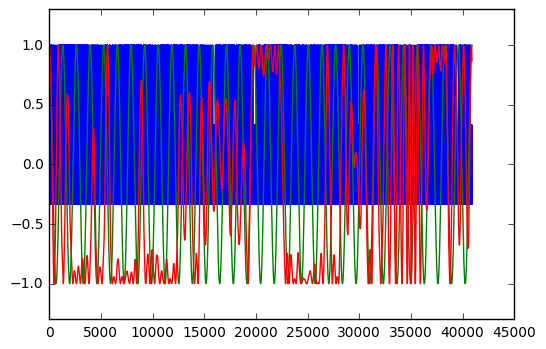

/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


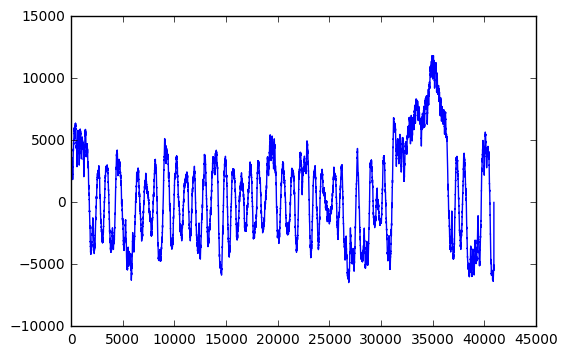

In [8]:
referenceWave = makWav(3100, 0, len(data.CData))

plt.plot(np.real(data.CData))#[10000:11000]))
plt.plot(np.real(referenceWave))#[10000:11000]))
#plt.plot(np.imag(data.CData))
plt.plot(np.real(refWave))#[10000:11000]))
         
plt.ylim([-1.3, 1.3])
plt.show()

#plt.plot(discriminator)
#plt.show()

plt.plot(rf)
plt.show()


In [9]:
incWav= data.CData

#Logging Vectors
refWave = np.zeros(len(incWav), dtype='complex')
m = np.zeros(len(incWav))
discriminator = np.zeros(len(incWav))
rf = np.zeros(len(incWav), dtype = 'complex')



#Initialize vars
freqHz = 3100
#baseF = np.exp(1j * 2 * np.pi * (freqHz/fs)) #Everything is in Hz until the end of the loop
refFreq = freqHz#baseF #Initial frequency

refphase = 1 + 0j #Initial phase

refWave[0] = refphase
adjustment = 0
oldErr = 0
oldRef = 0


#iterate over every sample and adjust
for n, samp in enumerate(incWav):
    #Mix
    mixed = incWav[n] / refWave[n]
    #m[n] = mixed
    
    #Check discriminator
    d = np.angle(mixed) / (2*np.pi)
    discriminator[n] = d #Save n + 1discriminator
    
    
    
    #Adjust frequency
    adjustment = oldRef + (d - oldErr) * (65) + d * 321
    
    refFreq = freqHz +  adjustment     
    oldRef = adjustment
    
    oldErr = d
    
    #Calculate next reference frequency sample
    if (n<len(incWav)-1):
        rf[n]= refFreq
        refWave[n + 1] = refWave[n] * np.exp(1j * 2 * np.pi * (refFreq/fs)) #Calculate phase step

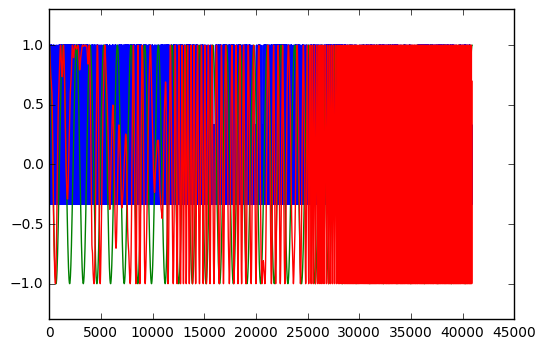

/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


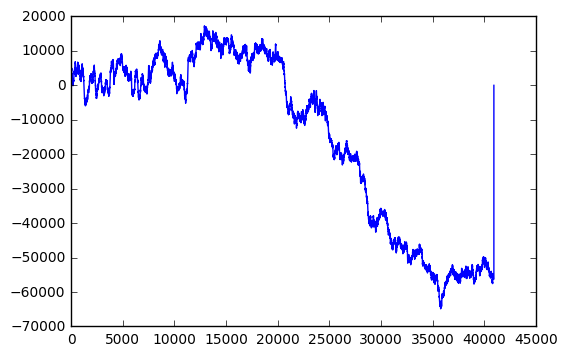

In [10]:
referenceWave = makWav(3100, 0, len(data.CData))

plt.plot(np.real(data.CData))#[10000:11000]))
plt.plot(np.real(referenceWave))#[10000:11000]))
#plt.plot(np.imag(data.CData))
plt.plot(np.real(refWave))#[10000:11000]))
         
plt.ylim([-1.3, 1.3])
plt.show()

#plt.plot(discriminator)
#plt.show()

plt.plot(rf)
plt.show()
